# Choosing a kernel for your GP
The critical piece for a Gaussian process is the kernel function that specifies how the covariance matrix looks. You can read all about how to choose them [here](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html). In this notebook I'll actually show you what happens when you choose different kernels for different problems, and what the effects are.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
import george.kernels as kernels
np.random.seed(123456)

## Kernel should resemble the data
In the kernel cookbook I linked, a general piece of advice is that you will get better performace from your GP/emulator if the kernel looks like your data, so using a periodic kernel for a periodic function is better than using the squared exponential (SE) function.
Let's start by messing with the Hogg data again and seeing what happens with different kernels.

In [2]:
data = np.genfromtxt("data.txt", skip_header=1, delimiter='&')

#These functions return the different parts of the
#Hogg data, specifically the 'good' and 'bad' sections.
def good_data():
    return data[4:,1:4].T

def bad_data():
    return data[:4, 1:4].T

def all_data():
    return np.concatenate((bad_data().T, good_data().T)).T

Optimization terminated successfully.


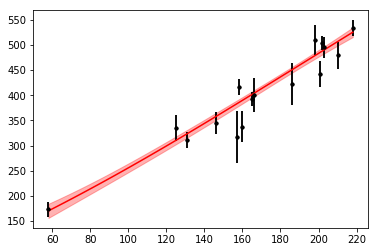

In [3]:
#Obtain and plot the data
x, y, yerr = good_data()
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
#Create a GP with the SE kernel, optimize, and then predict
kernel = kernels.ConstantKernel(1.0)*kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

This is the same GP we created in the last example. Let's see what happens when we make a simple change and use the SE kernel *without* including the $k_o$ variance as a hyperparameter, so now
$$k(x_i,x_j) = \exp\left(-\frac{(x_i-x_j)^2}{2\sigma^2}\right). $$

Optimization terminated successfully.


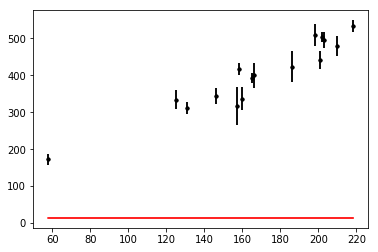

In [14]:
#Obtain and plot the data
x, y, yerr = good_data()
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
#Create a GP with the SE kernel without variance, optimize, and then predict
kernel = kernels.ExpSquaredKernel(1)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

Womp womp womp... The emulator fell on its face and failed miserably. This is because without the $k_0$ parameter out front to scale the covariance between everything the GP cannot handle this set of data. The good news is that this is a common enough problem that there is a fix! Oftentimes when working with GPs a very common thing to do is rescale your $y$ data so that it has unit variance and no mean, and then when the GP makes a prediction again you can just rescale and then add the mean back on.

Optimization terminated successfully.


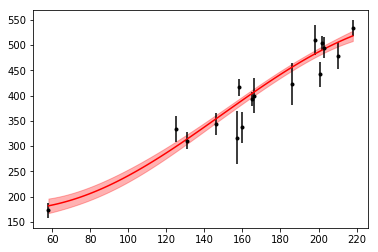

In [20]:
#Obtain and plot the data
x, y_initial, yerr_initial = good_data()
y_mean = np.mean(y_initial)
y_std = np.std(y_initial)
y = (y_initial - y_mean)/y_std
yerr = yerr_initial/y_std
#Create a GP with the SE kernel without variance, optimize, and then predict
L = np.mean(np.fabs(x[1:]-x[:-1]))
kernel = kernels.ExpSquaredKernel(L)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
mu *= y_std
mu += y_mean
err = np.sqrt(np.diag(cov))*y_std
plt.errorbar(x, y_initial, yerr_initial, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

### Some things to note
Rigth off the bat, you can see that this GP gives sort of a curvy fit, instead of the line we saw previously. This is not unexpected, since the kernel is differnt. You will also see that the original value we give the kenel (1 previously, now some mean distance between $x$ values) is different. As it turns out, finding the "best" hyperparameters is sensitive to the starting value you choose. I had originally picked 1, but found that the optimization routine couldn't get to an acceptable model, and this new choice is based on the data and gave something reasonable. Again, only trial and error will give you something that will work.

# Periodic kernel and extrapolation
You might have heard that GPs are only good for interpolation, but this isn't always true. Using the SE kernel does mean that you cannot extrapolate, but periodic kernels can be great for this task. Let's look at some periodic data as an example.

Optimization terminated successfully.


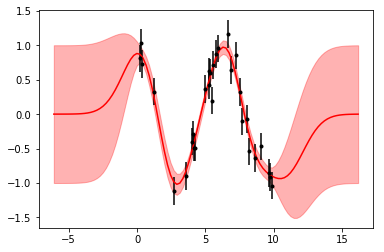

In [25]:
#Create some periodic data
N = 30
x = 10*np.sort(np.random.rand(N))
yerr = 0.2 * np.ones_like(x)
y = np.cos(x) + yerr * np.random.randn(len(x))
kernel = kernels.ExpSquaredKernel(2*np.pi)
gp = george. GP(kernel)
gp.optimize(x, y, yerr)
d = np.linspace(min(x)-2*np.pi, max(x)+2*np.pi, 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='k')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

As the GP extrapolates you can see that it defauls to the mean of the data, with error bars given by the standard deviation of the data. But we have an intuition that the data is probably periodic, so we might want the GP to remain periodic in its prediction. This is achieved with a different kernel.

Optimization terminated successfully.


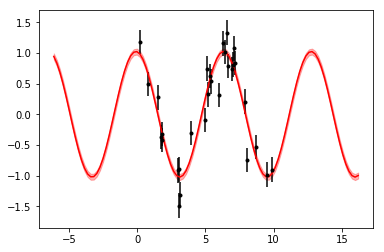

In [27]:
N = 30
x = 10*np.sort(np.random.rand(N))
yerr = 0.2 * np.ones_like(x)
y = np.cos(x) + yerr * np.random.randn(len(x))
kernel = kernels.CosineKernel(2*np.pi)
gp = george. GP(kernel)
gp.optimize(x, y, yerr)
d = np.linspace(min(x)-2*np.pi, max(x)+2*np.pi, 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='k')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

The kernel keeps its shape as it extrapolates! Very nice. The downside of using the `CosineKernel` from george is that it is currently only implemented in one dimension.

# Choosing the right kernel and hyperparameters
For a given problem choosing the kernel amounts to finding a kernel that looks most like your data and also does predictions as well as possible. An SE kernel can work for most problems, but if you ever need to extrapolate then a better choice would be a periodic kernel or perhaps some kind of power law kernel (see the cookbook). On top of that, if you are dealing with data that has underestimated errorbars, you can account for this by adding a `WhiteKernel` on, that essentially balloons the error bars on your data.

When finding the best hyperparameters, make sure to test the stability of your optimization routine by picking different starting points and re-running. If you want to be fully robust to this choice, then run an MCMC or some other sampling method to create full PDFs of the hyperparameters. This has the advantage that you can then propogate uncertainties on these parameters forward if the GP is used in a likelihood code.